In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn.preprocessing
import seaborn as sns
import plotly.graph_objects as go


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 3.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [6]:
#reading the data
path = 'dataset/dataset_new_germany.xlsx'
df = pd.read_excel(path, engine='openpyxl', index_col=0)

In [7]:
df.isnull().sum()

Messung Gebäude 2ewz [kWh]    0
dtype: int64

In [8]:
#renaming the columns
df.index.name ='datetime'
df.columns = ['energy']
df.head()

,energy
datetime,
2016-01-01 00:15:00,2.85
2016-01-01 00:30:00,2.85
2016-01-01 00:45:00,3.00
2016-01-01 01:00:00,2.94
2016-01-01 01:15:00,2.79


In [9]:
df['date'] = df.index.date
df['time'] = df.index.time
df['year'] = df.index.year
df['weekday'] = df.index.strftime("%A")
df.head()

,energy,date,time,year,weekday
datetime,,,,,
2016-01-01 00:15:00,2.85,2016-01-01,00:15:00,2016,Friday
2016-01-01 00:30:00,2.85,2016-01-01,00:30:00,2016,Friday
2016-01-01 00:45:00,3.00,2016-01-01,00:45:00,2016,Friday
2016-01-01 01:00:00,2.94,2016-01-01,01:00:00,2016,Friday
2016-01-01 01:15:00,2.79,2016-01-01,01:15:00,2016,Friday


/var/folders/5k/gnrk6j6x6z79v42dpz2bd76m0000gp/T/ipykernel_30548/3628703376.py:5: FutureWarning: The provided callable <function mean at 0x106cc71a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  _ = df.pivot_table(index=df['time'],


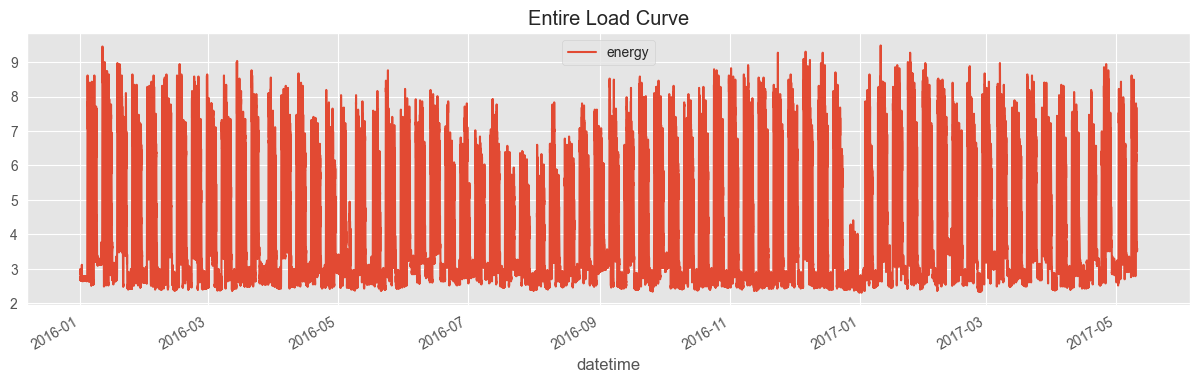

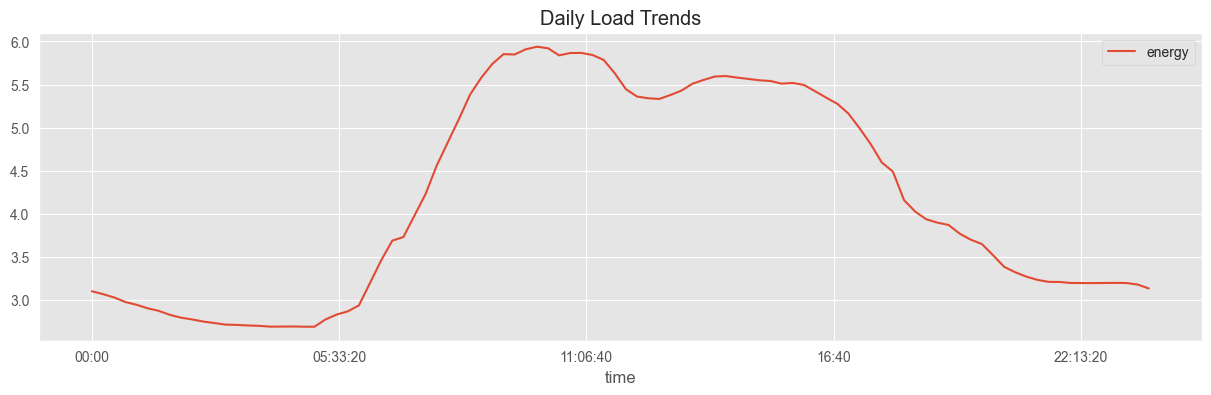

In [10]:
#Entire load curve and the daily load trends
_ = df.pivot_table(index=df.index, 
                     values='energy').plot(figsize=(15,4),
                     title='Entire Load Curve')
_ = df.pivot_table(index=df['time'], 
                     values='energy',
                     aggfunc=np.mean).plot(figsize=(15,4),
                     title='Daily Load Trends')

/var/folders/5k/gnrk6j6x6z79v42dpz2bd76m0000gp/T/ipykernel_30548/781489357.py:4: FutureWarning: The provided callable <function mean at 0x106cc71a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  _ = df.pivot_table(index=df['time'],


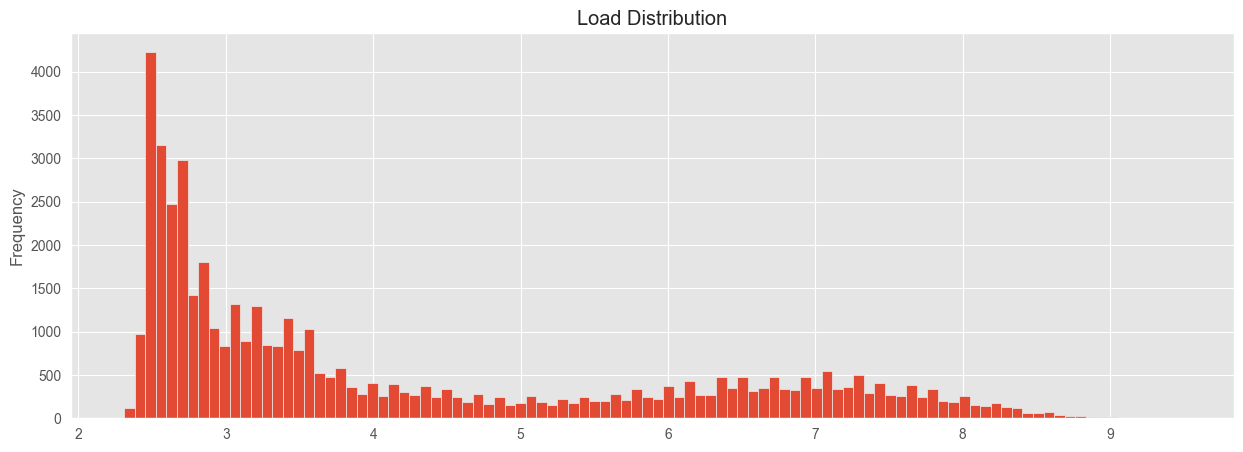

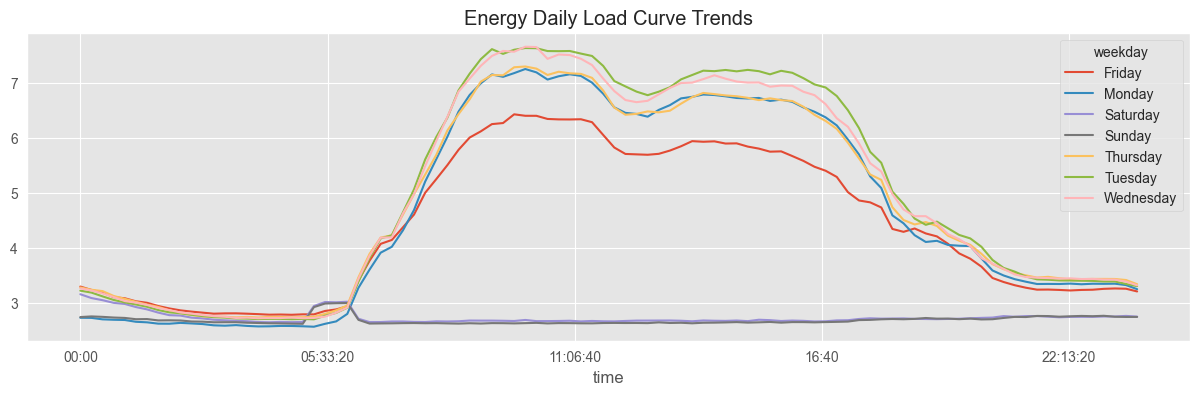

In [11]:
#Load distributions & daily load curve
_ = df['energy'].plot.hist(figsize=(15, 5), bins=100, title='Load Distribution')

_ = df.pivot_table(index=df['time'], 
                     columns='weekday', 
                     values='energy',
                     aggfunc=np.mean).plot(figsize=(15,4),
                     title='Energy Daily Load Curve Trends')

In [12]:
#normalize the energy data
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['energy']=scaler.fit_transform(df['energy'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm = df_norm.drop(columns=['date','time','year','weekday'])
df_norm.shape

(47581, 1)

In [13]:
df_norm.head()

,energy
datetime,
2016-01-01 00:15:00,0.075314
2016-01-01 00:30:00,0.075314
2016-01-01 00:45:00,0.096234
2016-01-01 01:00:00,0.087866
2016-01-01 01:15:00,0.066946


# Simple RNN Model by ignoring the anomalies

In [14]:
#data_loading
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    X_test = X_train[40000:]             
    y_test = y_train[40000:]
    
    X_train = X_train[:40000]           
    y_train = y_train[:40000]
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (40000, seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [15]:
seq_len = 20

X_train, y_train, X_test, y_test = load_data(df_norm, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (40000, 20, 1)
y_train.shape =  (40000,)
X_test.shape =  (7561, 20, 1)
y_test.shape =  (7561,)


In [16]:
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix


from keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_model = Sequential()

cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.15))

cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.15))

cnn_model.add(Flatten())
cnn_model.add(Dense(1))

cnn_model.summary()

2024-05-07 18:42:14.909239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/biagioboi/Desktop/unisa/research/hourEnergyConsumption/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
cnn_model.compile(optimizer="adam", loss="MSE")
cnn_model.fit(X_train, y_train, epochs=50, batch_size=80)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0037
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035
Epoch 10/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Epoch 11/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Epoch 12/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Epoch 13/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033
Epoch 14/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Epoch 15/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [18]:
# Make predictions using the CNN model
cnn_predictions = cnn_model.predict(X_test)

237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step


CNN Model R2 Score: 0.9307717512451339
CNN Model MSE: 0.004333393081019639


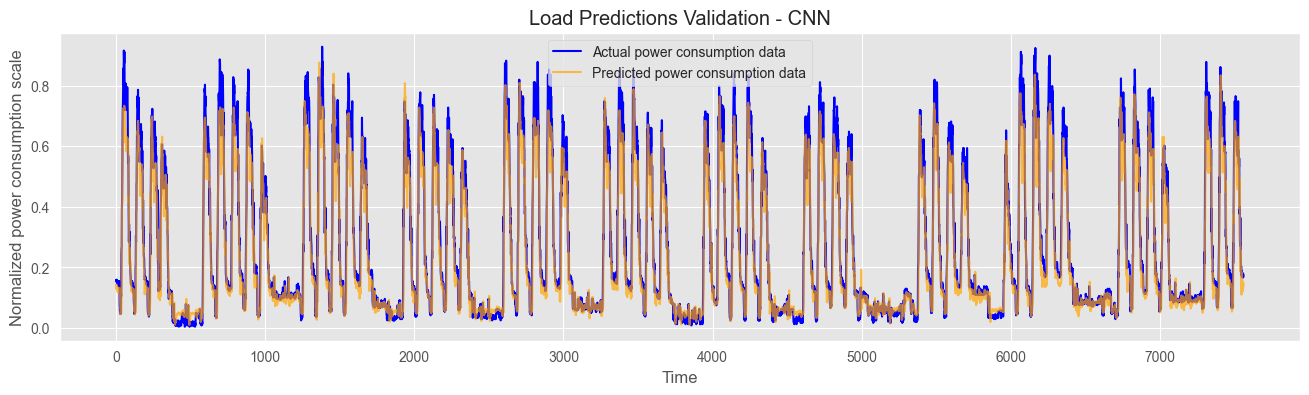

Confusion Matrix:
[[5601   44]
 [ 372 1544]]


In [22]:
# Evaluate the CNN model using R2 Score and MSE
cnn_r2 = r2_score(y_test, cnn_predictions)
cnn_mse = mean_squared_error(y_test, cnn_predictions)

print(f'CNN Model R2 Score: {cnn_r2}')
print(f'CNN Model MSE: {cnn_mse}')

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

# Plot predictions using the CNN model
plot_predictions(y_test, cnn_predictions, "Load Predictions Validation - CNN")

threshold_high = 0.5  # Adjust this threshold based on your problem

# Convert regression predictions to classification labels
cnn_class_predictions = np.where(cnn_predictions > threshold_high, 1, 0)
y_test_class = np.where(y_test > threshold_high, 1, 0)

# Calculate and display confusion matrix
conf_matrix = confusion_matrix(y_test_class, cnn_class_predictions)
print("Confusion Matrix:")
print(conf_matrix)

CNN Model R2 Score: 0.9307717512451339
Confusion Matrix:
[[5601   44]
 [ 372 1544]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5645
           1       0.97      0.81      0.88      1916

    accuracy                           0.94      7561
   macro avg       0.96      0.90      0.92      7561
weighted avg       0.95      0.94      0.94      7561



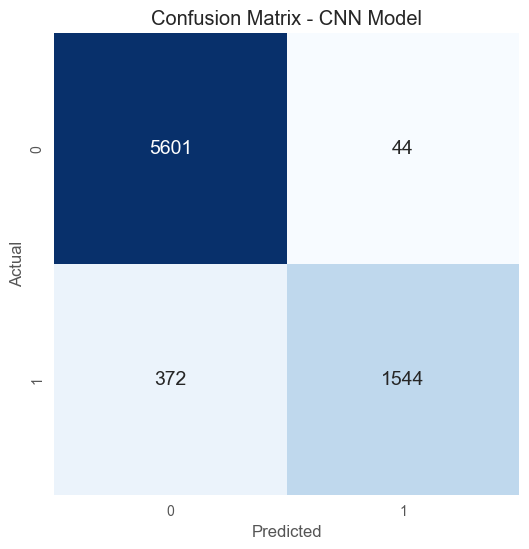

In [23]:
from sklearn.metrics import classification_report

threshold_high = 0.5
cnn_pred_classes = (cnn_predictions > threshold_high).astype(int)
y_test_class = (y_test > threshold_high).astype(int)

# Evaluation metrics
cnn_r2 = r2_score(y_test, cnn_predictions)
cnn_conf_matrix = confusion_matrix(y_test_class, cnn_pred_classes)

print("CNN Model R2 Score:", cnn_r2)
print("Confusion Matrix:")
print(cnn_conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test_class, cnn_pred_classes))

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cnn_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/Users/biagioboi/Desktop/unisa/research/hourEnergyConsumption/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 7, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0178
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0052
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0038
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
CNN Model R2 Score: 0.9502203236984856
Confusion Matrix:
[[5531  114]
 [ 180 1736]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5645
           1       0.94      0.91      0.92      1916

    accuracy  

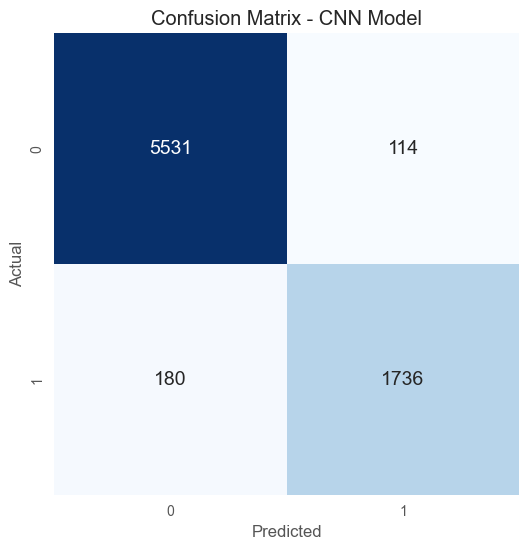

In [24]:
from sklearn.metrics import r2_score, confusion_matrix, classification_report

from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential

# Function to plot predictions
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

# Convert the RNl
cnn_model = Sequential()

cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.15))

cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.15))

cnn_model.add(Flatten())
cnn_model.add(Dense(1))

cnn_model.summary()

cnn_model.compile(optimizer="adam", loss="MSE")
cnn_model.fit(X_train, y_train, epochs=10, batch_size=80)

# Make predictions using the CNN model
cnn_predictions = cnn_model.predict(X_test)

# Convert predictions and actual values to binary classes (1 for anomaly, 0 for normal)
threshold_high = 0.5
cnn_pred_classes = (cnn_predictions > threshold_high).astype(int)
y_test_class = (y_test > threshold_high).astype(int)

# Evaluation metrics
cnn_r2 = r2_score(y_test, cnn_predictions)
cnn_conf_matrix = confusion_matrix(y_test_class, cnn_pred_classes)

print("CNN Model R2 Score:", cnn_r2)
print("Confusion Matrix:")
print(cnn_conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test_class, cnn_pred_classes))

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cnn_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [25]:
y_train

array([0.05857741, 0.05857741, 0.06276151, ..., 0.18410042, 0.15899582,
       0.16736402])